In [1]:
### PREAMBLE
# Graph and network processing
# roadNet-PA_graph.gif

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# Graphs

A great deal of data that you will encounter as a data scientist fundamentally involves network data, interrelated objects with relationships between them.  To give some very brief examples: social networks deal with people individuals and the friendship relations between them; web data deals with pages and the linking information between them; and spatial data (at a certain level of abstraction, we will deal more with spatial data in a few lectures), deals with objects and distances between them.

Before we start, it is worth specifying the difference in our terminology between a "network" and a "graph", both terms which are used to refer to the types of interelated objects that we will consider.  However, following fairly standard notation, in general "network" refers to the interrelation between actual entities _in the real world_, where as "graph" refers to the mathematical models for representing vertices and edges (which will often be used to represent networks).  A similar distinction came up previously in relational databases, between the actual entities that the data refered to, and the instantation of those entities in table form.

For the most part, these notes will be about _graph_ algorithms, but of course one of the primary uses of graph algorithms in data science is to reason about networks, which we will also do in this course.

## Graph models

Graphs as mathematical objects are _collections of vertices (also called nodes) and edges_.  We write this mathematically by stating that at graph is the tuple $G =(V,E)$ where $V$ is a set of vertices and $E$ is a set of edges (paris of vertices).  Let's consider the following graph

![A simple example of a graph object.](sample_graph.svg)

In this example, the nodes and edges are given by
\begin{equation}
\begin{split}
V &= \{A,B,C,D,E,F\} \\
E &= \{(A,B), (A,C), (B,C), (C,D), (D,E), (D,F), (E,F)\}
\end{split}
\end{equation}

i.e, there are six nodes, labeled A through F, and with edges corresponding to the lines between these nodes in the figure.  There are many different properties of graphs, but in these notes we'll focus on a few of the more common distinction between different types of graphs.

### Directed vs. undirected graphs
Graphs can be either _directed_ (the order of the edges matters, and indications some relation _from_ one node _to_ another, or they can be _undirected_, where the existence of an edge between two nodes implies a bidrectional relationship.  We typically draw directed graphs with arrows between the nodes to indicate direction, and undirected graphs without arrows, like so

![A directed graph.](directed.svg)

![An undirected graph.](undirected.svg)

The type of graph that is most appropriate for a given network of course depend on characteristics of that network.  A "web graph", where nodes represent pages, and edges represent links, would be best described by a directed graph: an edge from page A to page B represents a the fact that page A contains a link to page B.  This is a directed relationship, because such a link does not imply that page B also links to page A.  Note that in directed graphs we can absolutely have edges in both directions (i.e., if page A links to page B and page B links back to page A), but this needs to be sepcified by two separate edges in the graph.

An example of an _undirected_ graph would be a graph over authors and co-author relationships.  For instance, if we consider the authors of scientific papers as nodes in a graph, edges can represent whether the two authors have written a paper together.  This is an inherently non-directed relationship: if authors A wrote a paper with author B, there necessarily it is also the case that author B also write a paper with author A.

Although there will be some difference in algorithms/representations that are needed for directed vs. undirected graphs (the graph library NetworkX, for instance, has two different classes you need to use depending on the type of graph), but most of what we discuss here will apply equally well, potentially with just very minor modifications, to both types of graphs.

### Weighted vs. unweigthed graphs
Graphs can either be _weighted_ (edges between nodes have some real-valued weight associated with them), or _unweighted_ (all edges are equal).  We typically denote weighted graphs be writing the weight along edges.  For instance, a weighted version of the undirected graph above could be illustrated as follows:

![A weighted (and undirected) graph.](weighted.svg)

A graph that encoded distance between cities (say for the task of shortest-path planning, a topic that we will discuss shortly), would be best represented as a weighted graph, where the weigtht corresponded to distance between the cities. A simple social network graph, on the other hand, where nodes indicated people and edges indicates friendship, woudl likely be best represented as an unweighted graph, because (at least as far as the social newtork is concerned), friendship is simply a prescence/absence relationship, not a weighted quantity.

Note that there will be cases where the "right" reperesentation of the graph depends on the ultimate use case.  Consider the co-authorship network we described earlier.  This could be "naturally" represented as either an unweighted graph (where the presence of an edge merely signified that two people had a been a co-author on some paper), or a weighted graph (where the weight on an edge corresponds, say to the number of papers two co-authors have written together).  If our goal is to find "shortest paths" in coauthor relationships (for instance, the so-called [Erdős number](https://en.wikipedia.org/wiki/Erd%C5%91s_number) lists someone's distance from Paul Erdős, a famous mathematician known for extensive collaboration, in a co-authorship network), then an undirected graph would be most natural; there would be no real notion of "weight" to the edges in terms of the path.  On the other hand, if the goal was to assess some kind of community structure in the coauthorship graph (also a topic we will deal with shortly), then it makes sense that more papers imply some sort of closer relationship, and thus a weighted version of the graph would be more appropriate.

One point worth making is that real-valued weight on edges is in some sense a "special" feature to edges.  In general, graphs can have multiple properties and data associated with each node and edge; these can be used, for instance, in machine learning algorithms that operate directly on graphs.  However, edge weight is so common, and often can be directly incorporated into graph algorithms such as shortest path algorithms, that it has a special place in distinguishing types of graphs.

### Some example graphs

Although we will largely deal with "small" graphs here to emphasize the algorithmic elements (you will apply these to larger "real" graphs in the homework assignments), it's worth highlighting a few examples of real-world graphs.  The following pictures are taken from the the [SuiteSpasre Matrix Collection](https://sparse.tamu.edu/), and include graphs from the [Stanford Network Analysis Project (SNAP)](http://snap.stanford.edu).  For example, the following image illustrates the graph of road networks in Pennsylvania.

![Visualization of road network in Pennsylvania, from https://sparse.tamu.edu/SNAP/roadNet-PA](roadNet-PA_graph.gif)

Edges in this graph corresponds to roads in Pennsylvania, and color corresponds to the length of the road.  I like this graph because it represents well the "bottleneck" structure of the PA road system, where there are many short roads in the the Pittsburgh and Philadelphia regions, while there are fewer but much longer roads that connect the two urban areas of the state.

The above graph is "easy" to visualize because it is actually a representation of a two dimensional structure.  However, for more complex graphs, where there is not necessarily any underlying low-dimensional structure, it can be much harder to obtain any relevant information from the figure.  For example, the following graph from the same collection visualizing the connectivity of the LiveJournal social network.

![Visualization of the live journal social network, from https://sparse.tamu.edu/SNAP/soc-LiveJournal1](soc-LiveJournal1_graph.gif)


Despite being a pretty picture of a relatively large graph, and giving some indication that there are small "communities" indicated by the red dots on the outskits (densely connected nodes that are only sparsely connected to the rest of the graph), it is hard to interpret too much from this figure.

## Graph representations

Now that we have defined the very basic properties of graphs from a mathematical standpoint, we're going to consider how we can represent these graphs from a algorithmic standpoint.  We're going to use the notation and terms from the Python language here, but it's important to understand that the concepts here apply broadly (via the conceptual data structures of lists and/or dictionaries / hash maps).  Let's consider the simple directed graph we showed above, stated again here for simplicity.

![The directed graph we will consider for graph representations.](directed.svg)

It would be possible, of course, to just represent the graph like we did mathematically, something like:

In [9]:
nodes = {"A", "B", "C", "D"}
edges = {("A","B"), ("B","C"), ("C","A"), ("C","D")}

{'D', 'C', 'B', 'A'}


These are Python `set` objects, which are like a dictionary except that they just consist of keys, no values, and we're only using them here because a graph mathematically was defined precisely as a set of nodes and edges.  This may seem like a natural representation, but it has some major difficulties from a functionality standpoint.  For example, while it's relatively efficient to check if an edge exists in this representation (checking set membership is a $O(1)$ operation, just like dictionary lookup), it is very difficult, for example, to find all outgoing edges of a node, something we very often want to do when traversing graphs.  For this reason, it is much more common to represent graphs in other formats when we want to use them algorithmically.  We will specifically consider three of these here:

1. Adjacency list
2. Adjacency dictionary
3. Adjacency matrix


### Adjacency list

One of the simplest way to represent directed graphs is as a two-level list, where the elements in the list describe the nodes that each node is connected to.  To do this as a "pure" list, we first need to associate each node in the graph with an index, which we can do with a simple list.

In [4]:
nodes = ["A", "B", "C", "D"]
print(nodes)

['A', 'B', 'C', 'D']


Note that if we want a fast way of looking up nodes, we can create a dictionary of nodes to indices, like so.

In [5]:
nodes_dict = {"A":0, "B":1, "C":2, "D":3}
nodes_dict = {k:i for i,k in enumerate(nodes)}  # same as the above, done programmatically
print(nodes_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3}


We could accomplish the same thing just by using dictionaries directly, but since the idea of mapping general node labels like strings to integer indices is a useful conceptual idea (we'll need to do the same thing when we consider the adjacency matrix for, for instance), we will do that here as well.

More concretely now, the adjacency list format is a list of size $\mid V \mid$ (the number of vertices/nodes in the graph), where element in this list is _itself_ a list of all the nodes that this vertex connects to.  To encode the above graph, this would correspond to the following adjacency list.

In [ ]:
adj_list = [[1], [2], [0,3], []]

For example, this representation encodes the following facts:

* `adj_list[0] = [1]` means that node 0 ("A") has a link to node 1 ("B").
* `adj_list[1] = [2]` means that node 1 ("B") has a link to node 2 ("C").
* `adj_list[2] = [0,3]` means that node 2 ("C") has links to node 0 ("A") and node 3 ("D").
* `adj_list[3] = []` means that node 3 ("D") has no outgoing links.

In total, this describes the entire graph.  If we want to represent a weighted graph, we could use a tuple of `(node_index, weight)` pairs in the inner lists.

The adjacency list format is nice in that it allows us to quickly determine all (outgoing) neighbors of a node, which is a very useful operation for elements like shortest path algorithms.  On the other hand, unlike even the simple "set of edges" representation above, it is relatively expensive to check if some particular edge exists in the graph.  Because each list of outgoing edges is just represented as a list, if we want to check for the presence of an edge, we need to first find the initial node (a fast lookup), and then search that list to see if the outgoing edge exists (linear in the number of outgoing edges).

Another nice thing about the adjacency list representation, at least as it would be implemented with Python lists, is that adding additional additional nodes/edges to the graph is also constant time: we can just append the lists with the necessary additional edges.  Deleting an edge/node is more costly because of the additional cost associated with deleted elements in Python lists.

An obvious "fix", then, is to just replace the _list_ of outgoing edges with a _set_ of outgoing edges.  This is exactly what we'll do next, and in fact we'll transition everything to dictionaries/sets rather than maintain a separate list of "nodes" and "node indices" (this is mainly just out of convention, since once we move to including dictionary lookups, we may as well do everything with dictionaries).

### Adjacency dictionary

In order to make have constant time operations for both checking edge presence _and_ finding all the outgoing edges from a node, we can use an adjacency dictionary representation.  Here, the nodes are represented as keys in a dictionary, where the value of each node is another dictionary of outgoing edges (the values in this second dictionary can be empty, i.e., we could use a Python `set`, or they could be e.g., the weight on the respective edge).  Let's see how to represent the above graph, here using weights but explicitly setting them all to one.

In [12]:
adj_dict = {"A": {"B":1.0}, "B":{"C":1.0}, "C":{"A":1.0, "D":1.0}, "D":{}}

As before, the adjacency dictionary encodes the following facts:

* `adj_list["A"] = {"B":1.0}` means that node "A" has a link to node "B" (e.g. with weight 1.0)
* `adj_list["B"] = {"C":1.0}` means that node "B" has a link to node "C"
* `adj_list["C"] = {"A":1.0, "D":1.0}` means that node "C" has links to nodes "A" and "D"
* `adj_list["D"] = {}` means that node "D" has no outgoing links

In addition to the aforementioned benefits of having fast (constant time) edge lookup _and_ immediate lookup of all outgoing edges for a given node, the adjacency dictionary representation is very nice for very efficiently constructing and modifying graphs.  We can insert new nodes, insert new edge, delete edges, and delete nodes, all in constant time (this in an effect of all the corresponding operations being constant time for dictionaries).

Due to these benefits, this is in fact the representation that the [NetworkX](https://networkx.github.io/) library uses internally, which we'll discuss more later in these notes.

### Adjacency matrix

The final for of representation we'll consider is the adjacency matrix.  Because the rows/columns of a matrix are inherently indexed by integers, here we will need to return to the adjacency list concept of having a separate list for mapping from integer indices to node objects themselves.

In [13]:
nodes = ["A", "B", "C", "D"]
nodes_dict = {k:i for i,k in enumerate(nodes)}

The idea of an adjacency matrix is to store all edge information in a matrix $A \in \mathbb{R}^{\mid V \mid \times \mid V \mid}$ (where again $\mid V \mid$ denote the number of nodes) where there is an non-zero entry if the row $i$ and column $j$, $A_{ij}$ if and only if there is a corresponding is an edge from node $j$ to node $i$ (node the convention of ordering regarding rows/columns here, though it could just as easily be reversed).  The actual element in the matrix can be again the weigh of the edge, or just 1.0 if the graph is unweighted.  The matrix below would encode the example graph we have been using:
\begin{equation}
A = \left[ \begin{array}{cccc}
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \end{array} \right ]
\end{equation}

The advantage of the adjacency matrix representation comes when we want to perform efficient operations with respect to entire matrices.  We will see an example of this in the later section on the PageRank algorithm, but remember from the previous chapter on linear algebra, that matrix operations have been _highly_ optimized by various third-party libraries.  If we can express out matrix algorithms in terms of matrix and vector operations, we can often attain extremely efficient implementations with minimal detail in the implementation ourselves.

There is one more point work making about the adjacency matrix representation.  Since more graphs are sparse (i.e., they have relatively few of all possible edges), it makes sense to store them using a sparse matrix format.  And there is a very close connection between the sparse matrix representations we discussed in the last notes, and the representations we mentioned before.

Specifically, let's look at the compressed sparse column representation of the $A$ matrix.

In [ ]:
values = [1,1,1,1]
row_indices = [1, 2, 0, 3]
col_indices = [0, 1, 2, 4, 4]

Although it's a bit hard to see from this example, it shouldn't be too hard to convince yourself that the `row_indices` array is _exactly_ a "flattened" representation of the adjacency list representation we mentioned earlier (that is, instead of a list of lists, we just flatten all the elements sequentially into a 1D array).   It actually additionally requires that the edge list of each node be sorted, but assuming we have this property, the two representations are essentially identical.  And this makes perfect sense, too: the `row_indices` will be an ordered list of the non-zero rows for each column sequentially, which is exactly a list of all the outgoing edges for each node, by our definition of the adjacency matrix.  Likewise, the `col_indices` are going to just be a list of indices that begin each row, so we can look them up very quickly.  In fact, this is exactly what an efficient implementation of the adjacency list would look like, at least assuming that we aren't concerned with modifying the graph (remember the CSC format is particularly bad for modifying sparse matrices).  But hopefully this conveys the fact that from a data structure standpoint there actually a great deal of similarity between the matrix and list representations, and the matrix form will inherit most of the benefits of fast linear algebra libraries.

It's also work noting that the COO format of the adjacency matrix is essentially equivalent to a "list of edges" representation of the graph, must like our original "set of edges" representation we mentioned.  

## Graph algorithms

A single lecture in a data science course is naturally an inadequate setting to properly discuss graph algorithms, which is essentially an entire subfield of computer science in and of itself.  However, to start giving you just a taste of the types of tasks that people accomplish with graphs, we'll consider three different algorithms, each asking a slightly different question regarding the underlying network and/or graph.  This is also meant to highlight how we can use different representations of the graph to more "naturally" implement some of the different algorithms.  Specifically, we will cover:

1. Dijkstra's algorithm for computing single-source shortest path
2. The PageRank algorithm for computing node importance
3. The Girvan-Newman algorithm for community detection

### Dijsktra's algorithm

Given two nodes in a graph (directed or undirected, where weights represent "distances" between nodes, or all weights are equal in the case of an unweighted graph), suppose we want to find the shortest path between them.  This has some obvious applications like route planning maps, but also some less-obvious applications like the aforementioned example of computing someone's Erdős number given a graph of co-authorship relations.  The figure below gives (one) shortest path between the two blue nodes.

![Illustration of (a) shortest path between two nodes, assuming an unweighted graph](shortest_path.svg)

[Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) is a classic graph algorithm, which actually solves the _single-source shortest path_ problem (that is, it comes the shortest path from a single source node to _all_ other nodes in the graph).  It turns out that in many cases, you can get the all-shortest path solution "for free" if you compute the worst-case single-path between two nodes (that is, two nodes that are the furthest apart in the graph), so it's common to use these approaches instead of finding paths between just two nodes.

There are several slightly different version of Dijkstra's algorithm (for instance, there are versions that push neighboring nodes on to a queue only after a node has been visited, which also works in the case of single-path search), but we'll consider here a fairly standard version for the single-source problem.  The basic idea is to include maintain a _priority queue_, which we will call $Q$ in the algorithm below, that maintains the shortest distance from the source to each node in the graph.  When we pop a node off the queue (according to the shortest distance), we update the distance of all its neighbors to be the minimum of their current distance or the distance of the popped node plus the distance between the popped node as its neighbor.  Written in pseudocode, this takes the following form (assuming an unweighted graph, so the '1' below corresponds to the weight on edges ... this can be replaced with edge weight for a weighted graph).

<hr/>
**Algorithm**: Dijkstra's shortest path algorithm

**Given:** Graph $G = (V,E)$, source $s$

**Initialize:**
    
* $D[s] := 0$ 
* $D[i] := \infty$, $\forall i \neq s$
* $Q := V$

**Repeat until $Q$ is empty:**

* $i := $ Remove element from $Q$ with smallest $D$
* For all $j$ such that $(i,j) \in E$:

    * $D[j] = \min (D[j], D[i] + 1)$

<hr/>

Essentially, what this is doing is that we are expanding out from the source, always expanding the remaining node that is closest to the source, and updating the distance for all the neighbors of this node.

The precise complexity of Dijsktra's algorithm relies on the complexity of maintaining (and being able to modify) a priority queue of this type, the analysis of which is beyond the scope of this class.  But it should hopefully be apparent that there are about $O(\mid V \mid + \mid E \mid)$ queries that we need to make (since we're going to iterate over each vertex, and also ultimately iterate over all the edges ... the actual complexity with a well-designed priority queue is $O(\mid V \mid \log\mid V \mid + \mid E \mid)$ but we won't get into why this is the case).

Let's see how this algorithm looks step by step, looking at the distances and elements in $Q$ at each iteration, for the undirected graph, where "A" is the source node.

![An undirected graph.](undirected.svg)

At each step of the algorithm, we have the following elements:

* Initialization: $D=[0,\infty,\infty,\infty], Q=[A,B,C,D]$
* Step 1: Pop "A", $D=[0,1,1,\infty], Q=[B,C,D]$
* Step 2: Pop "B", $D=[0,1,1,\infty], Q=[C,D]$
* Step 3: Pop "C", $D=[0,1,1,2], Q=[D]$
* Step 4: Pop "D", $D=[0,1,1,2], Q=[]$

At the end of execution, $D$ contains the length of the shortest path from $s$ to all other nodes.

One final point is that if we want to know not only the length of the shortest path, but also the actual shortest path itself, we need to augment the algorithm to maintain a "pointer" to the actual previous element in the shortest path.  This will be considered in the homework question on Dijkstra's algorithm, as is also highlighted in the linked Wikipedia page on the algorithm, but it is a very simple modification of the algorithm.

### PageRank

PageRank is the algorithm that started Google.  As I'm writing this, Google has a Market Cap of $730 billion USD.  That is not bad for an algorithm that can be explained in a few slides.  [In case you're wondering, yes, the previous statement is facetious.  Google's actual initial technological advance was not just this algorithm, but a systems-based approach that could actually compute these results on a graph of the entire Web (albeit the web in 1997, which was significantly smaller, but then ago so were computers at that time).  And even then this was really just one advance of many that actually made Google into Google.  So be careful to ascribe _too_ much value to PageRank, even if it makes for a great story.]

Suppose you have a graph, and you want to somehow determine which nodes are "important".  For example, in the following graph, which nodes seem like the most important ones?

![A simple graph that illustrates possible considerations of node 'importance'](importance.svg)

You would probably say that the more "central" nodes are the more important ones here.  But how do we generalize this to bigger graphs?  To directed graphs? Is a node that just points to every other node an important one?  Or do we want to favor incoming edges over outgoing edges?  These questions are all impossible to answer "factually" in some sense, because they are ultimately subjective.  But the PageRank algorithm is one answer to these questions.  The historical context for the algorithm is that, traditionally, web search worked by trying to match a user's search string with the terms on a page; this works well in many cases, but it also tends to ignore whether or not "important" pages are being returned.  Especially for common search terms, a _lot_ of pages will match the terms, and how do we rank between these?  Google's answer was to compute the PageRank-based importance of each page, and sort between matching sites based upon this.

The central idea of PageRank is to consider what is called a _random walk_ over the graph.  You can think of this as browsing the web by randomly clicking on links, then seeing where you end up.  More formally, the process is as follows:

* Start at some random node in the graph
* Repeatedly jump to a random neighboring node
* If a node has no neighbors, jump
* (Optional) with probability $d$, jump to a random node

The node importance of PageRank is the probability that we wind up on page at any given time point, given that we have followed the procedure above for a long time.  Algorithmically, the method is as follows:

<hr/>
**Algorithm**: Page Rank

**Given:** Graph $G = (V,E)$, probability $d$, count $T$

**Initialize:**
    
* $A := $ adjacency matrix of $G$
* $P := $ replace all-zero columns of $A$ with all-ones, and normalize columns
* $\hat{P} :=  (1-d)P + \frac{d}{\mid V \mid}(11^T)$
* $x := \frac{1}{\mid V \mid} 1$
    

**Repeat $T$ times:**

* $x := \hat{P}x $

<hr/>

Let's see how this works for the directed graph we have considered above:

![Our directed graph, again.](directed.svg)

As discuss above, the adjacency matrix of this graph is given by:
\begin{equation}
A = \left[ \begin{array}{cccc}
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \end{array} \right ]
\end{equation}

To get the $P$ matrix, we first fill in the all-zeros column with ones, and then normalize the column (divide them by their sum):
\begin{equation}
P = \left[ \begin{array}{cccc}
0 & 0 & 0.5 & 0.25 \\
1 & 0 & 0 & 0.25 \\
0 & 1 & 0 & 0.25 \\
0 & 0 & 0.5 & 0.25 \end{array} \right ]
\end{equation}

Finally, we add $(1-d)P$ to $d$ times the "all-1/4" matrix (the all ones matrix normalized by column), with gives (supposing we shoose $d=0.1$)

\begin{equation}
\begin{split}
\hat{P} & = (1-d) \left[ \begin{array}{cccc}
0 & 0 & 0.5 & 0.25 \\
1 & 0 & 0 & 0.25 \\
0 & 1 & 0 & 0.25 \\
0 & 0 & 0.5 & 0.25 \end{array} \right ] +
d \left[ \begin{array}{cccc}
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \end{array} \right ] \\
&=
\left[ \begin{array}{cccc}
0.025 & 0.025 & 0.475 & 0.25 \\
0.925 & 0.025 & 0.025 & 0.25 \\
0.025 & 0.925 & 0.025 & 0.25 \\
0.025 & 0.925 & 0.475 & 0.25 \end{array} \right ]
\end{split}
\end{equation}



Let's see how we can do this is code.

In [64]:
import numpy as np

A = np.array([[0,0,1,0], [1,0,0,0], [0,1,0,0], [0,0,1,0]])
d = 0.1
T = 1000

P = A.copy()
P[:, P.sum(0) == 0] = 1
P = P / (P.sum(0)+1e-10)
Phat = (1-d)*P + d/A.shape[0]*np.ones(A.shape)
x = np.ones(A.shape[0])/A.shape[0]
for _ in range(T):
    x = Phat @ x
    x = x/x.sum()
print(x)

[ 0.21260745  0.26418338  0.31060172  0.21260745]


You can play around with this implementation to see what happens for different values of $d$.

**Note:** (this is very important, especially for your homework), that this is definitely _not_ an efficient implementation of PageRank, because it uses dense matrix representations, which won't fit in memory for any reasonably-sized graph.  To make PageRank actually feasible for large graphs, you need to use sparse matrix reprsentations.  But also note that adding all-ones rows and (especially) the all-ones matrix, if we did it naively, would of course eliminate any sparsity in the matrix.  So you need to handle these terms separately, which you can do using the fact the distributive property of matrix addition and multiplication, and by performing multiplications in the correct order.  You'll need to work these details out more in the homework.

### Girvan-Newman

The last algorithm we will consider here focuses on another problem in graphs, which has generated increasing interest in recent years, the problem of detecting "communities" in graphs.  Let's consider the following (undirected) graph.

![Example graph with clear instances of 'communities'](communities.svg)

Clearly, there are three subgraphs here that seem to form "communities", tighly knit subgrounds where most nodes are interconnected (they don't need to be fully connected, a type of subgraph formally called a "clique", but they are clique-like in that they are "almost" fully connected, by some definition), and which are only connected to other parts of the graph relatively sparsely.  Such communities play a large role in the analysis of social networks (the setting where the name is most appropriate, since these often correspond to actual communities of people), where it is common for small groups to all be friends with each other, and have relatively fewer connections outside the group.  But the use of community detection is also valuable in other types of graphs, for instance finding scientific subfields by looking at communities in paper citation graphs, or even finding biologically related functions by looking at protein interaction networks.

There are several different algorithms for finding communities, but one well-known approach is the Girvan-Newman algorithm, which was proposed in 2003.  To be more precise, the algorithm does not immediately produce a breakdown in the graph into communities, but instead a _dendrogram_, a hiearchical decomposition of the graph into related nodes, from which communities can be extracted.

The basic approach of the Girvan-Newman algorithm is to _remove_ edges from the graph one at a time, in the order of a property called _edge betweenness_ (more on this in a second).  If the graph is broken into two separate connected components, this becomes a hierarchical decomposition of the original graph.  This process in then repeated on both subgraphs recursively.  We aren't going to describe the algorithm in as much detail as Dijsktra's or the PageRank algorithm, mainly because the approach to actually computing the edge betweenness is somewhat involved, so we instead rely on a higher-level description of the algorithm in conceptual terms, with just hints at its implementation.

The edge betweenness property, which orders how we remove edges, is defined as _the number of shortest paths that pass through an edge, considering all pairs of shortest paths from and to each node in the network_ (in the case that there is more than one shortest path between two nodes, we divide the sum evenly over all the paths).   To illustrate this property, let's consider the following graph.

![Graph for illustrating edge betweenness.](gn.svg)

Since there are a lot of symmetries in the graph, we can specify all the edge betweenness factors by the following labels (all other betweenness factors are the same for the corresponding symmetric edges).

![Edge betweeness numbers.](gn_betweenness.svg)

Let's consider some examples.  The edge between nodes 1 and 2 has a betweenness of 1, because there is only one shortest path that spans this edge, the path between these two nodes; every other shortest path in the graph, from 1 to any other node, will instead go through node 3.  And similarly the 1--3 edge has a betweenness of 12, because there are 12 other nodes in the network (including node 3) where the shortest path must pass through this edge.  Now consider the 3--7 edge.  This case looks harder, until you realize that this edge is the only one that connects the two subgraphs with nodes (1,2,3) and (4,5,6,7,8,9,10,11,12,13,14); there are 3 nodes in one of these subgraphs and 11 in the other, so there must be 11 times 3 = 33 total shortest paths that path through this edge.  The same goes for the 7--8 edge: this divides two subgraphs of 7 nodes each, so the edge betweenness is 49.

These cases might give the impression that edge betweenness is fairly easy (because for a tree-structured graph, it is just a matter of counting the number of nodes on each side of the edge), but in general graphs it can be a bit more complex; computing it requires computing all pairs of shortest paths in the graph (for example using Dijkstra's algorithm above), and then accumulating the count of each time an edge is passed through.  For this reason, we won't dive into the algorithmic detail, but just show how the overall Girvan-Newman algorithm proceeds on the graph above.

To begin running Girvan-Newman on the above graph, we would remove the 7--8 edge, as it has the highest betweenness, dividing the graph as follows:

![First iteration of Girvan-Newman](gn_1.svg)

After this, we need to _recompute_ the edge betweeness in each of the subgraphs.  This is an important consideration: in general there is no easy way to "modify" betweenness of the modified graph after an edge is removed (unless of course the remove occurs on an entirely separate component), so we need to recompute the betweenness again from scratch.  In our example, at this point the 3--7, 6--7, 8--9, and 8--12 edges will all have the (same) highest betweenness, so we remove them all (it would be fine to only remove one and then proceed sequentially, but we can just as easily remove them all), resulting in the following graph.

![Second iteration of Girvan-Newman](gn_2.svg)

Running an additional iteration would remove all the remaining edges.  The process by which we removed edges implies the following dendrogram.

![Dendrogram formed by Girvan-Newman](dendrogram.svg)

This shows the hierarchical breakdown of the graph at all the different levels of the edge removals.  This in fact is the result of the Girvan-Newman algorithm; if we want to actual commit to some returned set of communities, we could cut this dendrogram at a specified level in the hierarchy, or perhaps decent the graphs until we find clusters of some prescribed size.  Regardless, the process itself has managed to break the graph down hierarchically into region that appear more and more "community-like" until we eventually just reach the nodes themselves.

As a final note, due to the need to compute all pairs of shortest paths (at each iteration of the algorithm), Girvan-Newman is not particularly computationally efficient.  More efficient community detection algorithms, such as those based upon Louvain clustering, are currently a bit more common in the literature, but the Girvan-Newman algorithm is still conceptually a very useful approach.

## The NetworkX graph library

As a final point in these notes, we want to briefly highlight the [NetworkX](http://networkx.github.io) graph library.  NetworkX is one of the most commonly-used graph libraries for Python, mainly because it has a huge collection of built-in algorithms (including, for instance, all the algorithms we considered in these notes, but of course also many many more.  It contains a simple interface for constructing both directed and undirected graphs, and performing a wide range of analyses.  It should be noted, however, that NetworkX is _not_ suitable for truly large-scale graphs: the graph structures and underlying algorithms are all implemented in native Python, meaning that very large-scale operations will be significantly slower than highly optimized compiled code. 

### Creating graphs

Let's start by importing the library and creating a graph.  Since the many more complex algorithms differ for directed and undirected graphs, NetworkX has separate classes for the two categories of graphs: `Graph` and `DiGraph` objects.

In [3]:
import networkx as nx
G_undirected = nx.Graph()
G_directed = nx.DiGraph()

Nodes in a NetworkX can be any hashable type (i.e., any type that can be used as a key in a dictionary, and in fact as we will see shortly, Network uses the adjacency dictionary representation of the graph internally).  We can add nodes using the `.add_node()` and `.add_nodes_from()` calls.  Similarly, we can remove nodes using the `.remove_node()` or `.remove_nodes_from()` calls.  Finally, a list of nodes can be given by the `.nodes()` call.

In [25]:
G = nx.Graph()
G.add_node("A")
G.add_nodes_from(["B","C"])
print(G.nodes())

['A', 'B', 'C']


In [27]:
G.remove_nodes_from(["A", "C"])
print(G.nodes())
G.add_nodes_from(["A", "C"])
G.remove_node("B")
print(G.nodes())

['B']
['A', 'C']


Edges can be added and removed from the graph using using the `.add_edge()` (add a single edge), `.add_edges_from()` (add a sequence of edges from a list), `.remove_edge()` and `remove_edges_from()` (similar to before).  Note that we can add edges between nodes that do not exist, and the relevant nodes are automatically added to the graph (for this reason, it is more common to simply add edges, rather than add nodes and edges separately, when constructing a graph).  Like the `.nodes()` call the `.edges()` call returns a list of edges in the graph, represented as tuples

In [29]:
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
print(G.nodes())
print(G.edges())

['A', 'B', 'C', 'D']
[('A', 'B'), ('B', 'C'), ('C', 'A'), ('C', 'D')]


In [30]:
G.remove_edge("A","B") 
print(G.edges())

[('B', 'C'), ('C', 'A'), ('C', 'D')]


In [31]:
G.remove_edges_from([("A","B"), ("B","C")])
print(G.edges(), weight)

[('C', 'A'), ('C', 'D')]


Removing a node will remove all the edges connected to that node.

In [54]:
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
G.remove_node("A")
print(G.edges())

[('B', 'C'), ('C', 'D')]


We can also add weights to edges via the `weight` attribute, though as we see, this is just a special case of more general edge attributes.

In [51]:
G = nx.DiGraph()
G.add_edge("A","B", weight=1.0)
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")], weight="4.0")

### Internal representations and node/edge data

Internally, NetworkX uses the adjacency dictionary representation to represent the graph.  We can access these elements by just indexing into the graph object itself.

In [57]:
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
print(G["C"])

{'A': {}, 'D': {}}


Remember that in an adjacency dictionary representation, the value for key "C" would be a dictionary, with keys corresponding to the nodes that "C" is connected to, just as we see above.  Note that by default, the value in this inner dictionary is itself an (empty) dictionary.  This dictionary is precisely where we store any relevant attributes for this edge.  For example, to add a "color" attribute to an edge, we just add the key/value pair to the edge.

In [61]:
G["A"]["B"]["color"] = "red"

The weight of an edge is just another attribute of this type, but NetworkX will know to treat the "weight" parameter properly for several of the underlying graph algorithms.

In [62]:
G["A"]["B"]["weight"] = 1.0
print(G["A"]["B"])

{'weight': 1.0, 'color': 'red'}


Obviously, node attributes cannot be added in quite the same way: the `G["A"]` dictionary couldn't be a method for adding node properties, as this is already how we represent the edges of node "A".  Instead, if we want to add node properties we use the `.node` property.

In [64]:
G.node["A"]["color"] = "blue"
print(G.node["A"])

{'color': 'blue'}


Finally, the `.nodes()` and `.edges()` lists by default will not return any of the attributes.

In [66]:
print(G.nodes())
print(G.edges())

['A', 'B', 'C', 'D']
[('A', 'B'), ('B', 'C'), ('C', 'A'), ('C', 'D')]


If we want to data returned too, we need to pass the `data=True` argument.

In [67]:
print(G.nodes(data=True))
print(G.edges(data=True))

[('A', {'color': 'blue'}), ('B', {}), ('C', {}), ('D', {})]
[('A', 'B', {'weight': 1.0, 'color': 'red'}), ('B', 'C', {}), ('C', 'A', {}), ('C', 'D', {})]


### Drawing graphs

NetworkX has some built in routines for drawing graphs, though generally speaking they do not produce the most visually compelling output.  Here is a simple illustration of the graph we have been working with.

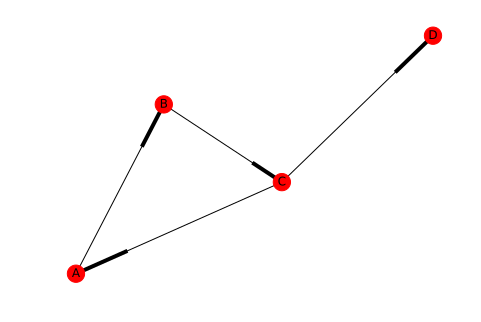

In [9]:
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
nx.draw(G, with_labels=True)

Direction are indicated by thick black lines, and positions are determined by randomly spacing out nodes.  It is somewhat functional for simple data exploration, but if you want to actually create nice drawings, you are better off using a graph visualization tool like [Graphviz](https://www.graphviz.org/), for which NetworkX has built-in support.  Here's an example of using Graphviz to visualize a graph.  Note that to do this, you'll need to install the [pygraphviz](https://pygraphviz.github.io/) package with the `conda install pygraphviz` (this will also install Graphviz).  

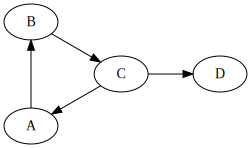

In [30]:
from IPython.display import SVG
A = nx.nx_agraph.to_agraph(G)
A.draw("out.svg", prog="circo")
SVG("out.svg")

Much nicer.  There are a few different `prog` arguments you can try out, which create different positional locations.  The most common, in addition to the `circo` we used here, are `dot`, and `neato`.

### Graph algorithms

Finally, NetworkX has a large number of graph algorithms built in.  A full list is here: [NetworkX algorithms](https://networkx.github.io/documentation/stable/reference/algorithms/index.html).  Let's look at just the algorithms we have described so far in these notes.  First let's consider the shortest path algorithm (generating either the path length or the path itself).

In [80]:
G = nx.Graph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
print(nx.shortest_path_length(G, source="A"))
print(nx.shortest_path(G, source="A"))

{'A': 0, 'B': 1, 'C': 1, 'D': 2}
{'A': ['A'], 'B': ['A', 'B'], 'C': ['A', 'C'], 'D': ['A', 'C', 'D']}


The PageRank implementation takes an `alpha` parameters which is $1-d$ is our notation.

In [82]:
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
nx.pagerank(G, alpha=0.9)

{'A': 0.2126075277037968,
 'B': 0.2641838185655828,
 'C': 0.31060112602682377,
 'D': 0.2126075277037968}

Finally, Girvan-Newman is a bit more involved, as it return the dendrogram as a sequence of successive breakdowns of the nodes.  Note that this sequence removes one edge at a time, so it only matches our figure at a few different points in the network, but it is hopefully apparent that this is doing the same thing as in our previous algorithmic description.

In [94]:
G = nx.Graph()
G.add_edges_from([(1,2), (1,3), (2,3), (4,5), (4,6), (5,6), 
                  (9,10), (9,11), (10,11), (12,13), (12,14), (13,14),
                  (3,7), (6,7), (7,8), (8,9), (8,12)])
communities = nx.community.girvan_newman(G)
list(communities)

[({1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12, 13, 14}),
 ({1, 2, 3}, {4, 5, 6, 7}, {8, 9, 10, 11, 12, 13, 14}),
 ({1, 2, 3}, {4, 5, 6, 7}, {9, 10, 11}, {8, 12, 13, 14}),
 ({1, 2, 3}, {4, 5, 6}, {9, 10, 11}, {8, 12, 13, 14}, {7}),
 ({1, 2, 3}, {4, 5, 6}, {9, 10, 11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2, 3}, {4, 5, 6}, {9, 10, 11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4, 5, 6}, {9, 10, 11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4}, {5, 6}, {9, 10, 11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4}, {5}, {6}, {9, 10, 11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4}, {5}, {6}, {9}, {10, 11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4}, {5}, {6}, {9}, {10}, {11}, {12, 13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4}, {5}, {6}, {9}, {10}, {11}, {12}, {13, 14}, {7}, {8}),
 ({1}, {2}, {3}, {4}, {5}, {6}, {9}, {10}, {11}, {12}, {13}, {14}, {7}, {8})]

## References

* [Dijskstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)
* [Page et al., "The PageRank Citation Ranking: Bringing Order to the Web."](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) (the PageRank paper)
* [Girvan and Newman, "Community structure in social and biological networks"](http://www.pnas.org/content/99/12/7821) (original source for Girvan-Newman algorithm)
* [NetworkX library](http://networkx.github.io)